#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Recommendation System by KNN (Content-Based Filtering)<Br><Br>
    
 - <span style="font-family:MV Boli; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> **Purpose:** Making a recommender to suggest music<Br><Br>
    
 - <span style="font-family:MV Boli; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Dataset: 
http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html
#####   

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Libraries

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
from   matplotlib import pyplot as plt

pd.set_option('display.max_rows'   ,2000)
pd.set_option('display.max_columns', 500)

# display results to 3 decimal points, not in scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x) 

import gc
from   scipy.sparse import csr_matrix

RANDOM_STATE = 7

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Loading and Exploring the Data
    
 - <span style="font-family:MV Boli; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> **df1 : Rated Products**
 - <span style="font-family:MV Boli; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> **df2 : Users**

In [2]:
Users   = pd.read_table('usersha1-profile.tsv',
                         header  =  None,
                         names   = ['users', 'gender', 'age', 'country', 'signup'],
                         usecols = ['users', 'gender', 'age', 'country', 'signup'])

Artists = pd.read_table('usersha1-artmbid-artname-plays.tsv',
                         header  =  None,
                         nrows   =  2e7,
                         names   = ['users', 'musicbrainz_artist_id', 'artist', 'plays'],
                         usecols = ['users', 'artist', 'plays'])

In [3]:
Users.tail(3)

,users,gender,age,country,signup
359344,fffe8c7f952d9b960a56ed4dcb40a415d924b224,m,20.000,United States,"Aug 8, 2007"
359345,ffff9af9ae04d263dae91cb838b1f3a6725f5ffb,m,20.000,Russian Federation,"Dec 3, 2005"
359346,ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,m,21.000,Belgium,"Nov 25, 2008"


In [4]:
Artists.tail(3)

,users,artist,plays
17535652,"sep 20, 2008",little man tate,11
17535653,"sep 20, 2008",sigur rós,10
17535654,"sep 20, 2008",the smiths,10


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Demographic Analysis (General)

In [5]:
def BarH(df,ft,n):
    L = df[ft].astype('str')
    L.value_counts(normalize=False).sort_values(ascending=True).tail(n).\
    plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan', figsize=(10,n/3))
    plt.show()    
    
    print( df[ft].value_counts().head(n) )

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Users

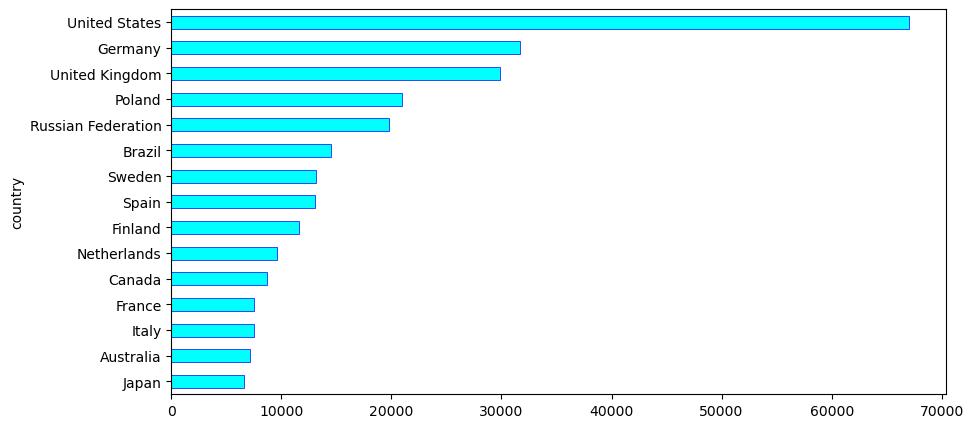

country
United States         67044
Germany               31651
United Kingdom        29902
Poland                20987
Russian Federation    19833
Brazil                14534
Sweden                13122
Spain                 13051
Finland               11579
Netherlands            9650
Canada                 8679
France                 7529
Italy                  7525
Australia              7135
Japan                  6637
Name: count, dtype: int64


In [6]:
BarH(Users,'country',15)

In [7]:
# Report
# Most Users are from US 
# Most European Users are from Germany and UK
# Most South American users are from Brazil
# Most Asian users are from Japan

In [ ]:
BarH(Users,'gender',2)

In [16]:
# Report
# most users are male

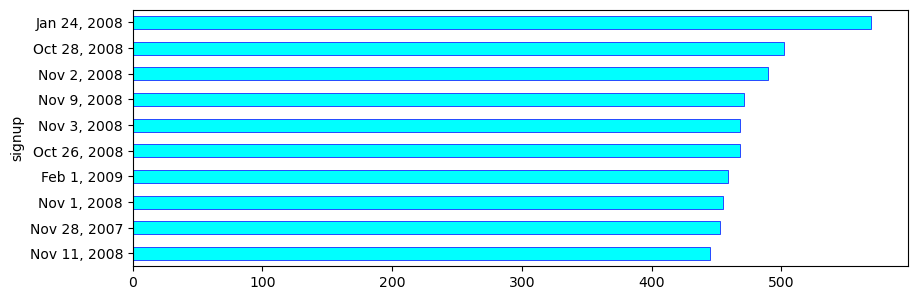

signup
Jan 24, 2008    569
Oct 28, 2008    502
Nov 2, 2008     490
Nov 9, 2008     471
Nov 3, 2008     468
Oct 26, 2008    468
Feb 1, 2009     459
Nov 1, 2008     455
Nov 28, 2007    453
Nov 11, 2008    445
Name: count, dtype: int64


In [9]:
BarH(Users,'signup',10)

In [10]:
# Question?
# What happened in this golden time that most signups happened?
# Which (Social-Media eg. facebook) Campains were then? 

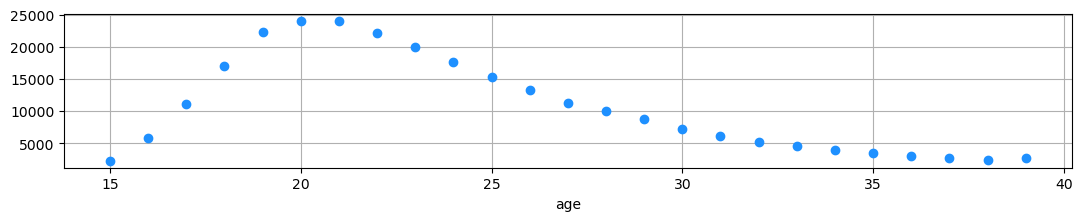

In [11]:
Users['age'].value_counts().head(25).plot(figsize=(13,2),linestyle='',marker='o',color='dodgerblue',grid='on'); plt.show()

In [12]:
# Report
# Majority of Users are between 17 to 28

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Artists

In [13]:
G = Artists.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns = { 'plays' : 'total_plays' } )
G.head(10)

,artist,total_plays
0,the beatles,30466827
1,radiohead,27426234
2,coldplay,16686772
3,pink floyd,15943557
4,metallica,15481852
5,muse,15451683
6,nine inch nails,14075619
7,red hot chili peppers,13547741
8,linkin park,12836638
9,system of a down,11917336


In [14]:
# Report
# Top Artists can be recommended to all users

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.8em; color:#00b3e5;"> US Only

In [16]:
US_Users = Users[ Users['country']=='United States' ].drop(['country'],axis=1)
US_Users.sample(3)

,users,gender,age,signup
255830,b685599ff57bf4df82e508342d970a8bef53c781,f,22.000,"Sep 22, 2005"
260838,ba29b8127a1d054a0fb2cb46f04cc35c68076d1d,m,NaN,"Feb 20, 2008"
60632,2b3efa94ca6cfefe9615cdb224cbca864ab7d6c1,NaN,31.000,"Aug 24, 2008"


In [20]:
US_Artists = Artists

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Clustering (US Only)

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> US_Users

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> US_Artists

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Demographic Analysis (US Only)

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> US_Users

In [17]:
US_Users['gender'].value_counts()

gender
m    42730
f    17804
Name: count, dtype: int64

In [553]:
# Report
# most US users are male

In [18]:
US_Users['signup'].value_counts().head(10)

signup
Jan 24, 2008    130
Apr 11, 2008    105
Jan 23, 2008    102
Jun 1, 2006      90
Jan 25, 2008     90
Jul 14, 2008     87
Jun 5, 2007      86
Oct 28, 2008     84
Jul 10, 2008     81
Jun 2, 2007      81
Name: count, dtype: int64

In [555]:
# Question?
# What happened in this golden time that most signups happened?
# Which (Social-Media eg. facebook) Campains were then? 

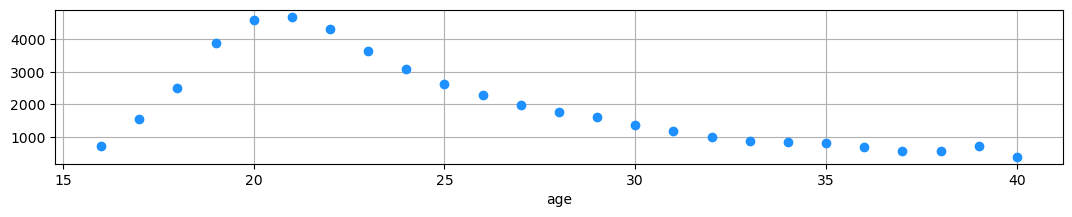

In [19]:
US_Users['age'].value_counts().head(25).plot(figsize=(13,2),linestyle='',marker='o',color='dodgerblue',grid='on')
plt.show()

In [21]:
# Report
# Majority of Users are between 17 to 29

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Merging (US Only)

In [21]:
US_Merged = pd.merge( US_Users, US_Artists, how='left', on='users' )

print(US_Merged.shape)
print(US_Merged['artist'].nunique())

US_Merged.head(3)

(3336367, 6)
114123


,users,gender,age,signup,artist,plays
0,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.000,"Jan 27, 2006",devendra banhart,456.000
1,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.000,"Jan 27, 2006",boards of canada,407.000
2,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.000,"Jan 27, 2006",cocorosie,386.000


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> dropping duplicates

In [22]:
US_Merged.drop_duplicates( inplace=True )

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> dropping null values
 - null values are rmoved from **Artists** only
 - null values of **Users** are not removed.

In [23]:
if US_Merged['artist'].isnull().sum() > 0:
    US_Merged = US_Merged.dropna( axis=0, subset=['artist'] )
US_Merged.isnull().sum()

users          0
gender    323868
age       732117
signup         0
artist         0
plays          0
dtype: int64

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Bucket Analysis on US_Merged

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> country = 'United States'

In [25]:
G  = US_Merged.groupby('artist')['plays'].sum().sort_values(ascending=False).reset_index()
G  = G.rename( columns={ 'plays' : 'total_plays' } )
US_General = G.copy()
US_General.head(3)

,artist,total_plays
0,the beatles,10705203.000
1,radiohead,7931815.000
2,death cab for cutie,4956608.000


In [26]:
# Report
# Top Atists can be recommended to all users in US

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> gender = 'm'

In [27]:
G = US_Merged[ US_Merged['gender']=='m' ] 
G.head(3)

,users,gender,age,signup,artist,plays
0,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.000,"Jan 27, 2006",devendra banhart,456.000
1,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.000,"Jan 27, 2006",boards of canada,407.000
2,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.000,"Jan 27, 2006",cocorosie,386.000


In [28]:
G = G.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns={'plays':'total_plays_m'} )
US_male = G.copy()
US_male.head(3)

,artist,total_plays_m
0,the beatles,6802376.000
1,radiohead,5342319.000
2,nine inch nails,2913291.000


In [31]:
# Report
# can be recommended to all 'male' users in US

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> gender = 'f'

In [29]:
G = US_Merged[ US_Merged['gender']=='f' ] 
G.head(3)

,users,gender,age,signup,artist,plays
200,00032c7933e0eb05f2258f1147ef81a90f2d4d6c,f,26.000,"Dec 5, 2008",parragon books,215.000
201,00032c7933e0eb05f2258f1147ef81a90f2d4d6c,f,26.000,"Dec 5, 2008",michael armstrong,114.000
202,00032c7933e0eb05f2258f1147ef81a90f2d4d6c,f,26.000,"Dec 5, 2008",alkaline trio,108.000


In [30]:
G = G.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns={'plays':'total_plays_f'} )
US_female = G.copy()
US_female.head(3)

,artist,total_plays_f
0,the beatles,2899601.000
1,death cab for cutie,1799600.000
2,radiohead,1762562.000


In [31]:
# Report
# can be recommended to all 'female' users in US

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> gender & age

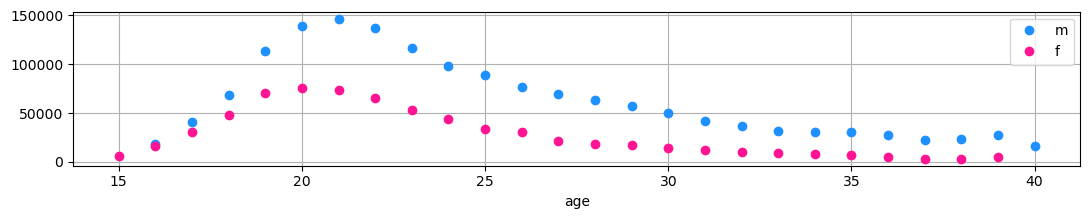

In [32]:
G = US_Merged[ US_Merged[ 'gender' ]=='m' ]
G['age'].value_counts().head(25).plot(figsize=(13,2),linestyle='',marker='o',grid='on',color='dodgerblue') 

G = US_Merged[ US_Merged[ 'gender' ]=='f' ]
G['age'].value_counts().head(25).plot(figsize=(13,2),linestyle='',marker='o',grid='on',color='deeppink') 

plt.legend('mf'); plt.show()

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> age buckets

 - 15-18
 - 19-23
 - 24-29
 - 30-35
 - 36-...

In [33]:
def create_age_bucket( x ):
    if   15<=x and x<19: return 'b1'
    elif 19<=x and x<24: return 'b2'
    elif 24<=x and x<30: return 'b3'
    elif 30<=x and x<36: return 'b4'
    else               : return 'b5'
    
G = US_Merged.copy()
G['age_bucket'] = G['age'].apply(create_age_bucket)
G = G[ ['users','gender','age','age_bucket','signup','artist','plays'] ]

Age_Bucket = G.copy()
Age_Bucket.sample(2)

,users,gender,age,age_bucket,signup,artist,plays
97479,078634b273a976ca8d83a6072ee5feab6830bcf1,f,27.000,b3,"Nov 28, 2006",murray gold,204.000
2206589,a94285dbc5f690a9b5f7cda3c267fa7b5a6a763a,f,22.000,b2,"Dec 25, 2008",the appleseed cast,37.000


<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> gender='m' & age buckets

In [36]:
M = Age_Bucket[ Age_Bucket['gender']=='m' ]
M = pd.merge( M, US_General, how='left', on='artist' )
M.sample(2)

,users,gender,age,age_bucket,signup,artist,plays,total_plays
1951273,ea175f4639f6860db65764bc2cd69ba33af55473,m,19.000,b2,"Aug 12, 2008",afi,365.000,1425918.000
503197,3bebc3bdecfb0705e58994242cafcc5d70a1cfc4,m,50.000,b5,"Nov 8, 2008",donell jones,2.000,23717.000


In [37]:
G = M[ M['age_bucket']=='b1' ]
G = G.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns={'plays':'total_plays'} )
M_B1 = G.copy()
M_B1.head(3)

,artist,total_plays
0,the beatles,475574.000
1,radiohead,334007.000
2,modest mouse,253785.000


In [38]:
G = M[ M['age_bucket']=='b2' ]
G = G.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns={'plays':'total_plays'} )
M_B2 = G.copy()
M_B2.head(3)

,artist,total_plays
0,the beatles,2606624.000
1,radiohead,2001388.000
2,death cab for cutie,1177083.000


In [39]:
G = M[ M['age_bucket']=='b3' ]
G = G.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns={'plays':'total_plays'} )
M_B3 = G.copy()
M_B3.head(3)

,artist,total_plays
0,radiohead,1319074.000
1,the beatles,1296145.000
2,nine inch nails,919712.000


In [40]:
G = M[ M['age_bucket']=='b4' ]
G = G.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns={'plays':'total_plays'} )
M_B4 = G.copy()
M_B4.head(3)

,artist,total_plays
0,the beatles,533113.000
1,radiohead,530143.000
2,nine inch nails,376646.000


In [41]:
G = M[ M['age_bucket']=='b5' ]
G = G.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns={'plays':'total_plays'} )
M_B5 = G.copy()
M_B5.head(3)

,artist,total_plays
0,the beatles,1890920.000
1,radiohead,1157707.000
2,pink floyd,671300.000


<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> gender='f' & age buckets

In [43]:
F = Age_Bucket[ Age_Bucket['gender']=='f' ]
F = pd.merge( F, US_General, how='left', on='artist' )
F.sample(2)

,users,gender,age,age_bucket,signup,artist,plays,total_plays
680783,c71014e25c90225fe9529676ad52d67535513d1d,f,23.000,b2,"Mar 24, 2008",the bird and the bee,24.000,152779.000
510649,9526235b57d216e30ada6d6179cf70d7fb8f4008,f,19.000,b2,"Jun 25, 2008",band of horses,64.000,656274.000


In [44]:
G = F[ F['age_bucket']=='b1' ]
G = G.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns={'plays':'total_plays'} )
F_B1 = G.copy()
F_B1.head(3)

,artist,total_plays
0,the beatles,383450.000
1,death cab for cutie,276604.000
2,fall out boy,260565.000


In [45]:
G = F[ F['age_bucket']=='b2' ]
G = G.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns={'plays':'total_plays'} )
F_B2 = G.copy()
F_B2.head(3)

,artist,total_plays
0,the beatles,1363398.000
1,death cab for cutie,930903.000
2,radiohead,826953.000


In [46]:
G = F[ F['age_bucket']=='b3' ]
G = G.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns={'plays':'total_plays'} )
F_B3 = G.copy()
F_B3.head(3)

,artist,total_plays
0,the beatles,537479.000
1,radiohead,376067.000
2,death cab for cutie,273588.000


In [47]:
G = F[ F['age_bucket']=='b4' ]
G = G.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns={'plays':'total_plays'} )
F_B4 = G.copy()
F_B4.head(3)

,artist,total_plays
0,the beatles,128423.000
1,radiohead,103087.000
2,tori amos,100667.000


In [48]:
G = F[ F['age_bucket']=='b5' ]
G = G.groupby('artist')['plays'].sum().sort_values(ascending=False)
G = G.reset_index().rename( columns={'plays':'total_plays'} )
F_B5 = G.copy()
F_B5.head(3)

,artist,total_plays
0,the beatles,486851.000
1,radiohead,320728.000
2,dean martin,296209.000


# 
# 

# 
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> US_Merged (Simplified)

In [50]:
US_Merged = US_Merged[ ['users','artist','plays'] ]

print(US_Merged.shape)
print(US_Merged['artist'].nunique()) 

pd.concat([US_Merged.head(2),US_Merged.tail(2)],axis=0,sort=False)

(3336237, 3)
114123


,users,artist,plays
0,00007a47085b9aab8af55f52ec8846ac479ac4fe,devendra banhart,456.000
1,00007a47085b9aab8af55f52ec8846ac479ac4fe,boards of canada,407.000
3336365,fffe8c7f952d9b960a56ed4dcb40a415d924b224,behemoth,40.000
3336366,fffe8c7f952d9b960a56ed4dcb40a415d924b224,green day,40.000


# 
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Groups

In [51]:
G1 = US_Merged.groupby('users')['artist'].count().sort_values(ascending=False).reset_index()
G1 = G1.rename( columns = { 'artist' : 'users_count' } )
G1.head(3)

,users,users_count
0,13c0df8a58cd3ca9e37d8e90662d2ad3c062eaa5,166
1,7679da839e1a6c2d299c7fd6834fb9bf6e229224,139
2,e85a4c61ca10501e09c979d411e984afc0a2393e,124


In [52]:
G2 = US_Merged.groupby('artist')['users'].count().sort_values(ascending=False).reset_index()
G2 = G2.rename( columns = { 'users' : 'artist_count' } )
G2.head(3)

,artist,artist_count
0,the beatles,22180
1,radiohead,18835
2,death cab for cutie,12905


In [53]:
G3 = US_Merged.groupby('artist')['plays'].sum().sort_values(ascending=False).reset_index()
G3 = G3.rename( columns = { 'plays' : 'plays_sum' } )
G3.head(3)

,artist,plays_sum
0,the beatles,10705203.000
1,radiohead,7931815.000
2,death cab for cutie,4956608.000


In [54]:
G4 = US_Merged.groupby('artist')['plays'].median().sort_values(ascending=False).reset_index()
G4 = G4.rename( columns = { 'plays' : 'plays_median' } )
G4.head(3)

,artist,plays_median
0,the novas,49933.000
1,big lonz,22202.000
2,栗原正己,15103.000


# 
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Adding Columns

In [55]:
df = US_Merged.copy()
df = pd.merge( df, G1, how='left', on='users'       )
df = pd.merge( df, G2, how='left', on='artist' )
df = pd.merge( df, G3, how='left', on='artist' )
df = pd.merge( df, G4, how='left', on='artist' )
df.head(3)

,users,artist,plays,users_count,artist_count,plays_sum,plays_median
0,00007a47085b9aab8af55f52ec8846ac479ac4fe,devendra banhart,456.000,50,2989,868311.000,171.000
1,00007a47085b9aab8af55f52ec8846ac479ac4fe,boards of canada,407.000,50,4314,1750033.000,187.000
2,00007a47085b9aab8af55f52ec8846ac479ac4fe,cocorosie,386.000,50,1434,382582.000,148.000


In [56]:
df = df[ ['users', 'users_count', 'artist', 'artist_count', 'plays', 'plays_median', 'plays_sum'] ]
df = df.sort_values(['artist_count','plays_sum','plays_median','users_count'],ascending=[False,False,False,False])
pd.concat([df.head(2),df.tail(2)],axis=0,sort=False)

,users,users_count,artist,artist_count,plays,plays_median,plays_sum
2601820,c79fe89cc6c1bdc52a8f4dd350a31f5ac87828db,121,the beatles,22180,5.000,218.000,10705203.000
1531926,75f98e69fb3288d5c25c48743a808efa2cb05be0,114,the beatles,22180,27.000,218.000,10705203.000
1308060,64b6b00138403ce6699bbc8c2d7cc55d593ff1c1,2,roy moller,1,1.000,1.000,1.000
2117996,a283b578d1553f1ef50666c2b39d07fe50811387,2,ginette garcin,1,1.000,1.000,1.000


In [57]:
del G1, G2, G3, G4

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> 5) EDA

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Descriptive Statistics

In [58]:
def BoxPlot(df,ft):
    boxprops    = dict( edgecolor = 'k', facecolor  = 'cyan', linewidth = 1 )
    medianprops = dict( color     = 'k', linewidth  = 1  )
    flierprops  = dict( marker    = 'd', markersize = 7, markerfacecolor = 'red', markeredgecolor = 'red' ) 
                  
    plt.figure(  figsize=(3,1)  )
    sns.boxplot( x=df[ft]
               , boxprops    = boxprops
               , medianprops = medianprops
               , flierprops  = flierprops  
               )
    plt.title(ft)
    plt.xlabel('') 
    plt.show()

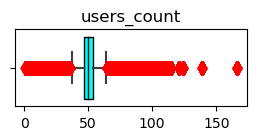

count   3336237.000
mean         51.008
std           7.771
min           1.000
25%          47.000
50%          50.000
75%          54.000
max         166.000
Name: users_count, dtype: float64

In [59]:
ft = 'users_count'
BoxPlot(df,ft)
df[ft].describe()

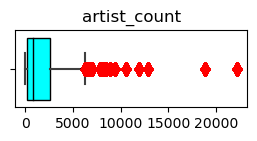

count   3336237.000
mean       1983.380
std        3122.889
min           1.000
25%         146.000
50%         759.000
75%        2576.000
max       22180.000
Name: artist_count, dtype: float64

In [60]:
ft = 'artist_count'
BoxPlot(df,ft)
df[ft].describe()

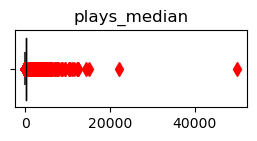

count   3336237.000
mean        127.322
std          77.676
min           1.000
25%          96.000
50%         126.000
75%         155.000
max       49933.000
Name: plays_median, dtype: float64

In [61]:
ft = 'plays_median'
BoxPlot(df,ft)
df[ft].describe()

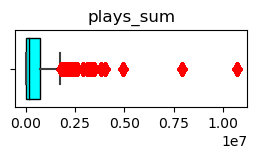

count    3336237.000
mean      632822.883
std      1260154.287
min            1.000
25%        30347.000
50%       191106.000
75%       722549.000
max     10705203.000
Name: plays_sum, dtype: float64

In [62]:
ft = 'plays_sum'
BoxPlot(df,ft)
df[ft].describe()

# Keeping only top titles (where no of plays are more)


In [63]:
DF = df.copy() 


threshold = DF['users_count'].quantile(.90)    # increase it to reduce number of records. It does not affect 'Artist'
DF = DF.query( 'users_count >= @threshold' )

threshold = DF['artist_count'].quantile( 0.10 )
DF = DF.query( 'artist_count >= @threshold' )

threshold = DF['plays_sum'].quantile( 0.05 )  
DF = DF.query( 'plays_sum > @threshold' )

threshold = DF['plays_median'].quantile( 0.05 )
DF = DF.query( 'plays_median >= @threshold' )



print( DF.shape )
print( DF['artist'].nunique() )
DF.head(3)

(292260, 7)
10154


,users,users_count,artist,artist_count,plays,plays_median,plays_sum
2601820,c79fe89cc6c1bdc52a8f4dd350a31f5ac87828db,121,the beatles,22180,5.000,218.000,10705203.000
1531926,75f98e69fb3288d5c25c48743a808efa2cb05be0,114,the beatles,22180,27.000,218.000,10705203.000
1070134,5232e4f87259cd9a0dda61873bd6b661caf3cdce,111,the beatles,22180,63.000,218.000,10705203.000


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> 6-1) Pivot Table<Br>
 - <span style="font-family:MV Boli; font-weight:Normal; font-size:1.1em; color:black;"> Making **Pivot Table** of **artist-name** & **users** & **plays**

In [64]:
# Making the Pivot Table of Title & Rating
df_Pivot = DF.pivot_table( index='users',columns='artist',values='plays').fillna(0)
df_Pivot.tail(3)

artist,!!!,!t.o.o.h.!,(+44),(hed) planet earth,*nsync,+/-,+44,...and oceans,...and you will know us by the trail of dead,...of sinking ships,1 giant leap,1 mile north,10 ft. ganja plant,10 years,"10,000 maniacs",100 demons,108,112,116 clique,12 rods,12 stones,1200 micrograms,12012,13 & god,1349,13th floor elevators,14 iced bears,14kt,16,16 horsepower,16volt,1905,1990s,1997,1tym,2 many dj's,2 many djs,2 pistols,2 skinnee j's,2 skinnee js,2*sweet,20 minute loop,25 ta life,2562,27,2gether,2nd chapter of acts,2ne1,2pac,2pm,2raumwohnung,3,3 doors down,3 inches of blood,30 seconds to mars,311,31knots,32 leaves,324,36 crazyfists,3oh!3,4 strings,40 below summer,40 winks,45 grave,4hero,50 cent,50 foot wave,50 lions,65daysofstatic,7 angels 7 plagues,7 generations,7 seconds,7 year bitch,702,764-hero,7l & esoteric,7seconds,8 bit weapon,808 state,86 mentality,88 fingers louie,88-keys,8ball & mjg,8mm,9 shocks terror,90 day men,98 degrees,999,99th floor elevators,9mm parabellum bullet,9th wonder,9th wonder & buckshot,:wumpscut:,[:sitd:],[unknown],a,a band of bees,a billion ernies,a camp,a certain ratio,a challenge of honour,a change of pace,a cursive memory,a day to remember,a different breed of killer,a dozen furies,a fine frenzy,a frames,a girl called eddy,a global threat,a guy called gerald,a hawk and a hacksaw,a life once lost,a loss for words,a love like pi,a northern chorus,a perfect circle,a perfect murder,a place to bury strangers,a plea for purging,a plus d,a rocket to the moon,a silver mt. zion,a skylit drive,a static lullaby,a sunny day in glasgow,a thorn for every heart,a tribe called quest,a weather,a whisper in the noise,a wilhelm scream,a*teens,a-ha,a-team,a-trak,a.a. bondy,a.c. newman,a.c.t,a.n.s.,aa,aaa,aaliyah,aarktica,aaron carter,aaron shust,aaron sprinkle,aaron watson,abacabb,abakus,abandoned pools,abba,abc news,abdullah ibrahim,abe froman,abe vigoda,aberdeen,aberfeldy,abfahrt hinwil,abigail,abigail washburn,abigail williams,abigor,abingdon boys school,able baker fox,abney park,aborted,aborym,above & beyond,above this fire,abscess,abstract rude,absu,absurd,absurd minds,abx,ac/dc,academy of st. martin in the fields,acappella,accept,acceptance,accessory,ace,ace enders and a million different people,ace hood,ace of base,aceyalone,achilles,acid,acid bath,acid black cherry,acid house kings,acid mothers temple & the melting paraiso u.f.o.,acidman,aco,acoustic alchemy,across five aprils,across the universe,across the universe soundtrack,action action,acumen nation,adagio,adam again,adam and the ants,adam ant,adam carolla,adam green,adam johnson,adam lambert,adam pascal,adam richman,adam sandler,add n to (x),adele,adem,adema,adham shaikh,adolescents,adorable,adrian belew,adrian johnston,adrian orange,adriana calcanhotto,adriana evans,adrianne,adult.,advantage lucy,advent,aeon,aereogramme,aerosmith,aes dana,aesop rock,aesthetic perfection,afghan whigs,afi,african head charge,afro celt sound system,afro celts,afro melt,afroman,after forever,after the burial,afu-ra,afx,against all authority,against me!,agalloch,agathocles,agathodaimon,...,world's end girlfriend,woven hand,wu-tang clan,wussy,wwe,wyclef jean,wye oak,wynardtage,wynton marsalis,x,x japan,x-ecutioners,x-fusion,x-mal deutschland,x-ray dog,x-ray spex,xandria,xasthur,xavier rudd,xbishopx,xbxrx,xela,xerxes,xfilesx,ximena sariñana,xiu xiu,xlooking forwardx,xoc,xotox,xploding plastix,xtc,xzibit,y&t,ya boy,yacht,yacøpsæ,yael naim,yagya,yak ballz,yann tiersen,yanni,yaphet kotto,yazoo,yeah yeah yeahs,year of the rabbit,yeasayer,yelle,yello,yellow magic orchestra,yellowcard,yellowjackets,yes,yesterday's new quintet,ying yang twins,yiruma,ymck,yngwie malmsteen,yo gotti,yo la tengo,yo-yo ma,"yo-yo ma, edgar meyer, mark o'connor",yob,yoko ono,yonder mountain string band,yoshida brothers,you am i,you me at six,you say party! we say die!,"you, me, and everyone we know",young buck,young dro,young galaxy,young jeezy,young love,young marble giants,young widows,youngblood brass band,young

In [65]:
df_Pivot.shape

(5399, 10154)

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> 6-2) CSR

In [66]:
CSR_Matrix = csr_matrix( df_Pivot.T.values )
CSR_Matrix

<10154x5399 sparse matrix of type '<class 'numpy.float64'>'
	with 292259 stored elements in Compressed Sparse Row format>

In [67]:
CSR_Matrix.shape

(10154, 5399)

In [68]:
CSR_Matrix[-2].data

array([59.])

In [69]:
CSR_Matrix.data

array([ 206.,    7.,   78., ..., 2404.,   59.,  695.])

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> 7) KNN model

In [70]:
from sklearn.neighbors import NearestNeighbors
Model_KNN = NearestNeighbors( metric='cosine', algorithm='brute' )
Model_KNN.fit( CSR_Matrix )

NearestNeighbors(algorithm='brute', metric='cosine')

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> 8A) Recommending ( Ratings + KNN )

 - <span style="font-family:MV Boli; font-weight:Normal; font-size:1.1em; color:black;">  Finding the **Item of Interest** in the **Pivot Table**<Br>
 - <span style="font-family:MV Boli; font-weight:Normal; font-size:1.1em; color:black;">  Finding the **Neighbors** of **Item of Interest**  Using  **KNN**
 - <span style="font-family:MV Boli; font-weight:Normal; font-size:1.1em; color:black;">  **Recommending Neighbors**

In [73]:
#Item_of_Interest = 'britney spears'
#Item_of_Interest = 'jennifer lopez'
#Item_of_Interest = 'abba'
#Item_of_Interest = 'michael jackson' 
#Item_of_Interest = 'lady gaga'
#Item_of_Interest = 'shakira'
#Item_of_Interest = 'cher'
#Item_of_Interest = 'linkin park'
Item_of_Interest = 'madonna'
#Item_of_Interest = 'katy perry' 
#Item_of_Interest = 'the beatles'
#Item_of_Interest = 'blondie'
#Item_of_Interest = 'pink floyd'
#Item_of_Interest = 'kenny g' 
#Item_of_Interest = 'mandy moore'
#Item_of_Interest = 'avril lavigne'
#Item_of_Interest = 'aqua'
#Item_of_Interest = 'spice girls'
#Item_of_Interest = 'janet jackson'
#Item_of_Interest = 'robbie williams'
#Item_of_Interest = ''
#Item_of_Interest = ''
#Item_of_Interest = ''

# Finding the  Item of Interest  in the  Pivot Table Zero
xx = df_Pivot[Item_of_Interest]

# Finding the  Neighbors  of the  Item of Interest  Using  KNN
distance, indices = Model_KNN.kneighbors(xx.values.reshape(1,-1), n_neighbors=201 )

print('\nItem of Interest:',Item_of_Interest)
print('\n\nSuggested  Items:')

# Recommending Neighbors
new = pd.DataFrame()
new['Distance'] = np.round( list(distance[0]) ,3 )
new.index = list( df_Pivot.iloc[ :,list( indices[0] ) ].columns )
new = new[ new['Distance']<1.0 ]
new.style.bar( subset=['Distance'], color='yellow' )



Item of Interest: madonna


Suggested  Items:


,Distance
madonna,0.000000
jennifer hudson,0.501000
kylie minogue,0.554000
mariah carey,0.556000
rupaul,0.562000
deborah cox,0.594000
thalía,0.612000
phil collins,0.619000
all-4-one,0.621000
sophie ellis-bextor,0.623000


#####   
# 8B) Recommending ( Ratings + Correlations )
 - Finding the **Item of Interest** in the **Pivot Table**
 - Finding the **Correlation** of **Item of Interest** with the **Pivot Table**
 - **Recommending** Highly Correlated Items

In [495]:
# Finding Item of Interest in the Pivot Table
Item_Ratings = df_Pivot[ Item_of_Interest ]

# Finding Correlation of  Item of Interest  with the  Pivot Table
r = df_Pivot.corrwith( Item_Ratings )
r = pd.DataFrame(r,columns=['Correlations'])
r = r.dropna()


In [496]:
# Recommending Highly Correlated Items
new = r.copy()
#new = new.join( df_Grouped['weighted_rating'], on='title' )
#new = new.join( df_Grouped[  'rating_count' ], on='title' )

new['Correlations'] = np.round( new['Correlations'], 2 )

new = new[ new[  'Correlations'  ]>.25 ]  #.75
#new = new[ new['weighted_rating' ]>3.0 ]  #3.0
#new = new[ new[  'rating_count'  ]>40  ]  #40

new = new.sort_values(['Correlations'
                       #,'weighted_rating','rating_count'
                      ],ascending=[False
                                   #,False,False
                                  ])

print('\nItem of Interest:',Item_of_Interest)
print('\n\nSuggested  Items:')

np.random.seed(3)
cm = sns.light_palette("cyan", as_cmap=True)
new.head(2000).style.\
    background_gradient(subset=['Correlations'], cmap=cm).\
    highlight_null(color="green").\
    format(precision=3)   #.to_excel('styled.xlsx', engine='openpyxl')


Item of Interest: abba


Suggested  Items:


,Correlations
artist,
abba,1.000
bee gees,0.460
kate bush,0.450
bow wow wow,0.450
japan,0.440
tubeway army,0.440
chris cornell,0.430
duran duran,0.420
george michael,0.390


#####   

#####   